### Dataset to use - change this value to analyze a different data set

In [1]:
dataset = 'twenty'

### Load in parent probabilities and rates

In [2]:
from analysis import check_gies

In [3]:
dag_folders = check_gies.get_dag_folders(dataset)
true_dags = check_gies.get_true_dags(dag_folders)
print('loaded DAGs')
parent_probs_by_dag = check_gies.get_parent_probs_by_dag(dag_folders, 10)
print('Computed parent probabilities')

loaded DAGs
Computed parent probabilities


### This little section is to check the results from the rates_da. Can be deleted

In [4]:
import numpy as np

In [14]:
alphas = np.linspace(0, 1, 11)
avg_tprs = np.zeros(len(alphas))
avg_fprs = np.zeros(len(alphas))
for a_ix, alpha in enumerate(alphas):
    tprs = []
    fprs = []
    for dag_num, (true_dag, parent_probs_by_strat) in enumerate(zip(true_dags, parent_probs_by_dag)):
        true_parents = true_dag.parents[10]
        true_nonparents = true_dag.nodes - true_parents - {10}
        labelled_parents = {p for p, prob in parent_probs_by_strat['learn-parents,n=60,b=2,k=2'].items() if prob >= alpha}
        true_positives = true_parents & labelled_parents
        false_positives = true_nonparents & labelled_parents
        tprs.append(len(true_positives) / len(true_parents) if len(true_parents) != 0 else 1)
        fprs.append(len(false_positives) / len(true_nonparents) if len(true_nonparents) != 0 else 0)
    avg_tprs[a_ix] = np.mean(tprs)
    avg_fprs[a_ix] = np.mean(fprs)

In [15]:
avg_tprs

array([1.        , 0.78468069, 0.64318937, 0.5587117 , 0.48572351,
       0.40992063, 0.3440753 , 0.28142303, 0.23870432, 0.15276855,
       0.03255814])

### Load the rates DataArray, a 7-dimensional tensor mapping each strategy (strategy name, n, b, k) and significance level to the value of a rate for all DAGs

In [34]:
strategy_names = ['random', 'edge-prob', 'learn-parents']
ks = [2]
bs = [2, 3]
ns = [60, 120]

In [35]:
rates_da = check_gies.get_rates_data_array(
    parent_probs_by_dag,
    true_dags,
    target=10,
    strategy_names=strategy_names,
    ks=ks,
    bs=bs,
    ns=ns,
    alphas=np.linspace(0, 1, 11)
)
print(rates_da.dims)

Loading parent probabilities for DAG 0
Loading parent probabilities for DAG 10
Loading parent probabilities for DAG 20
Loading parent probabilities for DAG 30
Loading parent probabilities for DAG 40
('strategy', 'k', 'b', 'n', 'alpha', 'rate', 'dag')


### Plot curves for each strategy

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
%matplotlib inline
sns.set()

In [41]:
linestyles = ['solid', 'dashed']

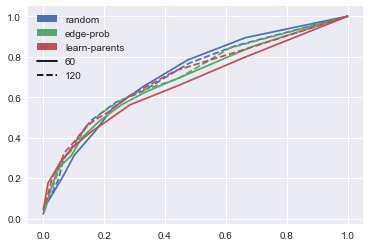

In [42]:
rate_avgs_da = rates_da.mean(dim='dag')
for strategy, color in zip(strategy_names, sns.color_palette()):
    for n, linestyle in zip(ns, linestyles):
        strat_avg_tprs = rate_avgs_da.sel(strategy=strategy, b=3, k=2, n=n, rate='tpr').values
        strat_avg_fprs = rate_avgs_da.sel(strategy=strategy, b=3, k=2, n=n, rate='fpr').values

        sort_ixs = np.argsort(strat_avg_fprs)
        plt.plot(strat_avg_fprs[sort_ixs], strat_avg_tprs[sort_ixs], linestyle=linestyle, color=color)

strat_handles = [
    mpatches.Patch(facecolor=color, label=s)
    for s, color in zip(strategy_names, sns.color_palette())
]
sample_handles = [
    mlines.Line2D([0], [0], color='k', linestyle=linestyle, label=n) 
    for n, linestyle in zip(ns, linestyles)
]
plt.legend(
    handles=strat_handles + sample_handles
)
plt.xlabel('Average FPR')
plt.ylabel('Average TPR')
plt.legend();